# Supervised Machine-Learning : Support Vector Machine classifier for credit cards default

We are using data from the UCI Machine Learning Repisotory, specifically the [default of credit card clients dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients), in order to predict if someone will default on their credit card payments based on numerous metrics such as sex, age, marital status and many others.

**Raw data are stored in the `data` -> `raw` directory of the Git repository.**

**All scripts used to transform raw data into features for modeling and scripts for the model are located in the `feature` and `model` directory, but will be displayed in the notebook for all to see.**

**Variable documentation can be found in the `reference` directory.**

In [1]:
import pandas as pd 
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
file_path= '/Users/eudes/Documents/Portfolio/SVM-default-credit-cards/data/raw/default_of_credit_card_clients.tsv'

In [3]:
def load_data(file_path):
    """
    Load the credit card clients data from a specified file.

    Parameters:
    file_path (str): The path to the data file.

    Returns:
    pd.DataFrame: The loaded DataFrame.
    """
    df = pd.read_csv(file_path, header=1, sep='\t')
    df.rename({'default payment next month': 'DEFAULT'}, axis='columns', inplace=True)
    return df

In [4]:
df = load_data(file_path)
df.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [5]:
# We can see a lot of variables in our dataset 

column_documentation_file = '/Users/eudes/Documents/Portfolio/SVM-default-credit-cards/references/SVM_default_credit_cards_dict.txt'

def parse_column_documentation(file_path):
    """
    Parse column documentation from a text file and store it in a dictionary.

    Parameters:
    - file_path (str): The file path to the text file containing column documentation.

    Returns:
    - dict: A dictionary where keys are column names and values are their respective descriptions.
    """
    column_docs = {}
    with open(file_path, 'r') as doc_file:
        for line in doc_file:
            parts = line.strip().split(':')
            if len(parts) == 2:
                column_name = parts[0].strip()
                column_description = parts[1].strip()
                column_docs[column_name] = column_description
    return column_docs

def get_column_description(df, column_name):
    """
    Get the description of a specific column from the parsed column documentation.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the columns.
    - column_name (str): The name of the column for which you want to retrieve the description.

    Returns:
    - str: The description of the specified column. If no description is available, it returns "No documentation available."
    """
    if column_name in column_documentation:
        return column_documentation[column_name]
    else:
        return "No documentation available."

In [6]:
column_documentation = parse_column_documentation(column_documentation_file)
for column_name, description in column_documentation.items():
    print(f"{column_name}: {description}\n")

ID: The ID number assigned to each customer

LIMIT_BAL: Amount of the given credit

SEX: Gender (1 = male; 2 = female)

EDUCATION: Level of education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

MARRIAGE: Marital status (1 = married; 2 = single; 3 = others)

AGE: Age (years)

DEFAULT: (1= Yes; 0=No)



## Data preprocessing

We can see there is a lot of variables in our dataset, some more useful than others, we can drop ID because it's doesn't give us information for our task.

In [7]:
def delete_columns(df, columns_to_delete):
    """
    Delete specified columns from a DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame from which columns will be deleted.
    columns_to_delete (list of str): A list of column names to be deleted from the DataFrame.

    Returns:
    DataFrame: A new DataFrame with the specified columns removed.
    """
    df = df.drop(columns=columns_to_delete, axis=1)
    return df

In [8]:
df = delete_columns(df, 'ID')

First and foremost, we have to check if we have missing values and deal with them

In [9]:
df.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

All of our varibales are numeric characters, which means we don't have a mix of letters and numbers. In other words, there are no **NA** values, or other character based place holders for missing data, in **df**.

We also have categorical variables, we should check for **NA** too

In [10]:
df['SEX'].unique(), df['EDUCATION'].unique() , df['MARRIAGE'].unique()

(array([2, 1]), array([2, 1, 3, 5, 4, 6, 0]), array([1, 2, 3, 0]))

Education like Marriage contains values which are not defined in the database description, we can guess 0 represent missings values, so we have to deal with them

# Dealing With Missing Data

Since scikit-learn's support vector machines do not support datasets with missing values, we need to figure out what to do with  the 0s in the dataset. We can either delete these customers from the training dataset, or impute values for the missing data. First let's see how many rows contain missing values.

In [11]:
len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)]), len(df)

(68, 30000)

68 values out of 3000 could be missings values, since it's ~1% of our global values, we still have much than necessary to perform our Support Vector Machines, so we don't need to replace the missing values we can just erase the row with 0 in the database

In [12]:
def filter_dataframe(df, columns_to_filter):
    """
    Filter a DataFrame based on specified columns.

    This function filters the input DataFrame to exclude rows where all the specified columns
    have values equal to 0.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame to be filtered.
    - columns_to_filter (list): A list of column names to be used for filtering.

    Returns:
    - pandas.DataFrame: The filtered DataFrame.
    """
    # Create a condition that checks if all specified columns are not equal to 0
    condition = df[columns_to_filter].ne(0).all(axis=1)
    
    # Use the condition to filter the DataFrame
    filtered_df = df.loc[condition]
    
    return filtered_df

In [13]:
columns_to_filter = ['EDUCATION', 'MARRIAGE']
df = filter_dataframe(df, columns_to_filter)

In [14]:
df['EDUCATION'].unique() , df['MARRIAGE'].unique()

(array([2, 1, 3, 5, 4, 6]), array([1, 2, 3]))

In [15]:
len(df)

29932

In [16]:
df['EDUCATION'].unique() , df['MARRIAGE'].unique()

(array([2, 1, 3, 5, 4, 6]), array([1, 2, 3]))

# Downsample the data

**Support Vector Machines** are great with small datasets, but not awesome with large ones, and this dataset is big enough to take a long time to optimize with Cross Validation. So we will downsample both categories, customers who did and did not default to 1,000 each.

To make sure we get **1,000** of each category, we start by splitting the data into two dataframes /

- one for people that did not default 
- one for people that did default

In [17]:
def downsample_dataframe(df, column_to_downsample, n_samples=1000, random_state=42):
    """
    Downsample a DataFrame based on a specified column.

    This function performs downsampling on the input DataFrame by randomly selecting a
    specified number of samples from each category in the specified column.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame to be downsampled.
    - column_to_downsample (str): The name of the column to be used for downsampling.
    - n_samples (int): The number of samples to downsample to (default is 1000).
    - random_state (int): The random seed for reproducibility (default is 42).

    Returns:
    - pandas.DataFrame: The downsampled DataFrame.
    """
    # Split the DataFrame based on the specified column
    categories = df[column_to_downsample].unique()
    downsampled_dfs = []

    for category in categories:
        subset_df = df[df[column_to_downsample] == category]
        downsampled_subset = resample(subset_df, replace=False, n_samples=n_samples, random_state=random_state)
        downsampled_dfs.append(downsampled_subset)

    # Combine the downsampled DataFrames
    downsampled_df = pd.concat(downsampled_dfs)

    return downsampled_df

In [18]:
df_downsample = downsample_dataframe(df, 'DEFAULT', n_samples=1000, random_state=42)

In [19]:
len(df_downsample)

2000

**It's a good practice to put the transformed data into the `data/intermediate` directory**

In [20]:
df_downsample.to_csv(r'/Users/eudes/Documents/Portfolio/SVM-default-credit-cards/data/interim/processed_data.csv')

# Split the Data into Dependent and Independent Variables

Now that we have taken care of the missing data, we are ready to start formatting the data for making a **Support Vector Machine**.

1. The columns of data that we will use to make classifications
2. The column of data that we want to predict (whether or not someone defaulted on a payment).

# One-Hot Encoding

Now that we have split the data frame into two pieces, `X`, which contains the data we will use to make, or predict, classifications, and `y`, which contains the known classifications in our training dataset, we need to take a closer look at the variables in `X`. The list bellow tells us what each variable represents and the type of data (**Int** or **Categorical**) it should contain:

- **LIMIT_BAL**, The amount of available credit **Integer**
- **SEX**, **Category**
  - 1 = male
  - 2 = female
- **EDUCATION**, **Category**
  - 1 = graduate school
  - 2 = university
  - 3 = high school
  - 4 = others
- **MARRIAGE**, **Category**
  - 1 = Married
  - 2 = Single
  - 3 = Other
- **AGE**, **Integer**
- **PAY_**, When the last 6 bills were payed **Category**
  - -1 = Paid on time
  - 1 = Payment delayed by 1 month
  - 2 = Payment delayed by 2 months
  - ...
  - 8 = Payment delayed by 8 months
  - 9 = Payment delayed by 9 or more months
- **BILL_AMT**, What the last 6 bills were **Integer**
- **PAY_AMT**, How much the last payments were **Integer**
- **DEFAULT**, Whether or not a person defaulted on the next payment **CATEGORY**
  - 0 = Did not default
  - 1 = Defaulted
  
  
It looks like **SEX**, **EDUCATION**, **MARRIAGE** and **PAY_** are supposed to be categorical and need to be modified. This is because, while **Support Vector Machines** from scikit-learn natively support continuous data, like **LIMIT_BAL** and **AGE**, they do not natively support categorical data, like **MARRIAGE**, which contains three different categories. In order to use categorical data, we have to converts a column of categorical data into multiple columns of binary values via One-Hot Encoding.

In [21]:
def preprocess_data(df, target_column, categorical_columns=[]):
    """
    Prepare features and target variables.

    Parameters:
    - df: The DataFrame containing the data.
    - target_column (str): The name of the target variable column.
    - categorical_columns (list): List of column names to be one-hot encoded (if applicable).

    Returns:
    - DataFrame: Features DataFrame with one-hot encoding applied to
      specified categorical columns.
    - Series: Target variable Series.
    """
    # Create the target variable Series
    y = df[target_column].copy()

    # Create features DataFrame by dropping the target column
    X = df.drop(target_column, axis=1).copy()

    # Perform one-hot encoding on categorical columns
    X_encoded = pd.get_dummies(X, columns=categorical_columns)
    
    return X_encoded, y

In [22]:
categorical_columns=['SEX',
         'EDUCATION',
         'MARRIAGE', 
         'PAY_0',
         'PAY_2',
         'PAY_3',
         'PAY_4',
         'PAY_5',
         'PAY_6']

In [23]:
X_encoded, y = preprocess_data(df_downsample, 'DEFAULT', categorical_columns = categorical_columns)

# Format the Data Part 3: Centering and Scaling

The **Radial Basis Function (RBF)** that we are using with our Support Vector Machine assumes that the data are centered and scaled. Each column should have a $\mu=0$ and a $\sigma=1$. We split the data into training and testing datasets and then scale them separately to avoid Data Leakage.

In [24]:
def split_and_scale_data(X, y, random_state=42):
    """
    Split and scale the data into training and testing sets.

    Parameters:
    - X: Features DataFrame.
    - y: Target variable Series.
    - random_state (int): Random seed for reproducibility (default is 42).

    Returns:
    - DataFrame: X_train_scaled - Scaled training features.
    - DataFrame: X_test_scaled - Scaled testing features.
    - Series: y_train - Training target variable.
    - Series: y_test - Testing target variable.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

    # Fit a StandardScaler on the training data and transform both training and testing data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [25]:
X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale_data(X_encoded, y, random_state=42)

# Preliminary Support Vector Machine

Text(0.5, 1.0, 'Normalized confusion matrix')

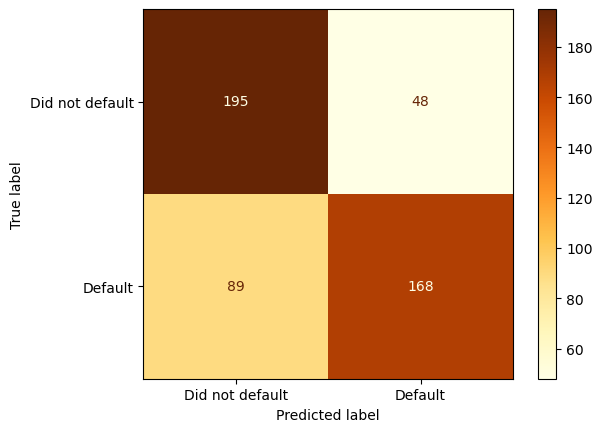

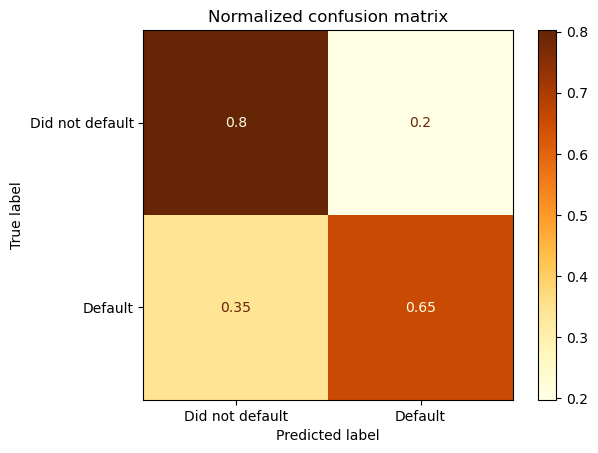

In [26]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf_svm,
        X_test_scaled,
        y_test,
        display_labels=["Did not default", "Default"],
        cmap=plt.cm.YlOrBr,
        normalize=normalize,
    )
disp.ax_.set_title(title)

In the confusion matrix, we see that of the **243** people that did not default, **195 (80%)** were correctly classified. And of the **257** people that defaulted, **168 (65%)** were correctly classified. So he **Support Vector Machine** was not awesome. Let's try to improve predictions using **Cross Validation** to optimize the parameters.

# Building, Evaluating, Drawing and Interpreting the Final Support Vector Machine

# Optimize Parameters with Cross Validation and GridSearchCV()

Let's try to find the best value for **gamma**, and, if we can, the regularization parameter **C**.

We will use `GridSearchCV()` to optimize these two parameters.

In [27]:
def train_model(X, y):
    """
    Train the machine learning model using cross-validation and grid search.

    Parameters:
    X (DataFrame): Features (input variables) for training.
    y (Series): Target variable for training.

    Returns:
    XGBoostClassifier: The best-trained XGBoost model found by grid search.
    """
    # Define the machine learning model
    model = SVC(random_state=42)

    # Define hyperparameters for grid search
    param_grid =  {'C': [0.5, 1, 10, 100],
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf'],
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=param_grid,
                                 scoring='accuracy',
                                 cv = 5,
                                 verbose=2)

    grid_search.fit(X, y)

    # Print the best hyperparameters
    print("Best Hyperparameters:", grid_search.best_params_)
    

    return grid_search.best_estimator_

In [28]:
hist = train_model(X_train_scaled, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.5, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.5, gamma=0.

[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.3s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.3s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END ...................

Corresponding to the Cross-Validation results,  `C=100`, `gamma=0.001` was the best parameters.

Text(0.5, 1.0, 'Normalized confusion matrix')

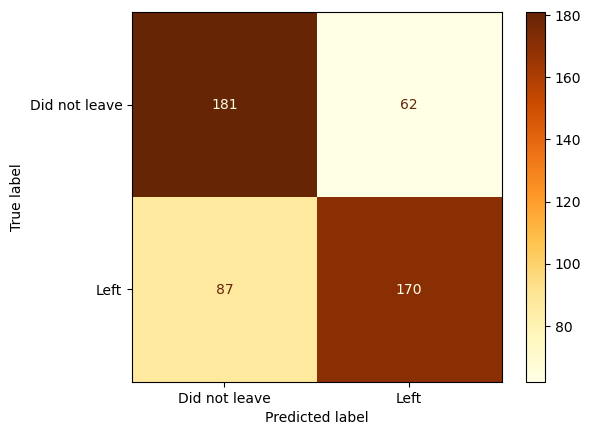

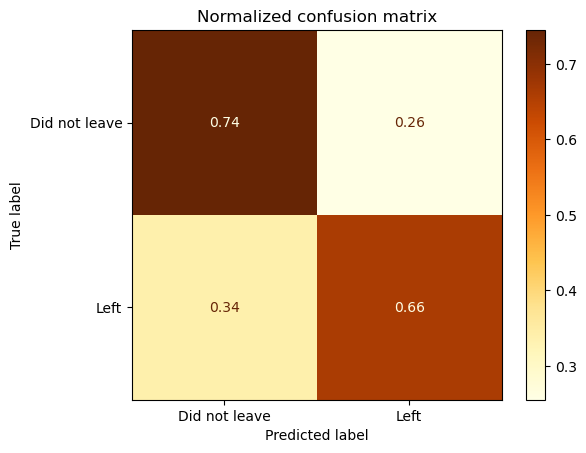

In [29]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        hist,
        X_test_scaled,
        y_test,
        display_labels=["Did not leave", "Left"],
        cmap=plt.cm.YlOrBr,
        normalize=normalize,
    )
disp.ax_.set_title(title)

And the results from the *optimized* **Support Vector Machine** are just a little bit better than before. **2** more people were *correctly* classified as defauting.

**To conclude** : The **SVM** was pretty good straight out of the box without much optimization. This makes **SVMs** a great and quick method for relatively small datasets.

#### Finally, we save our model in the `models` section of the Git repository.

In [30]:
model_path = '/Users/eudes/Documents/Portfolio/SVM-default-credit-cards/models/hist.pkl'

# Save the SVM model to the file using pickle
with open(model_path, 'wb') as model_file:
    pickle.dump(hist, model_file)

### Extra : PCA shape

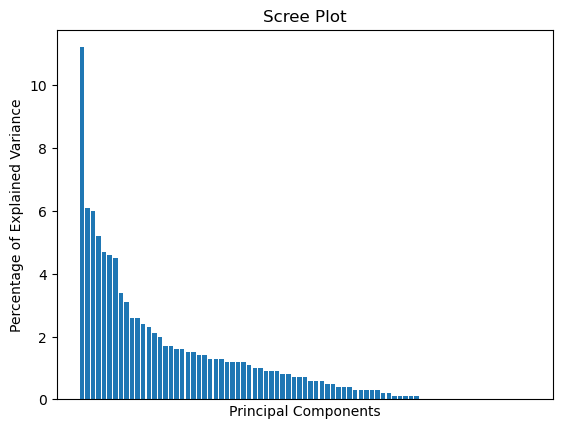

In [31]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',          
    which='both',     
    bottom=False,     
    top=False,        
    labelbottom=False)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

The scree plot shows that the first principal component accounts for a relatively large amount of variation in the raw data, so it will be a good candidate for the x-axis in the 2-dimensional graph. 